In this project, you need to program a bot that automatically trades stocks for you. The bot
should use sophisticated machine learning algorithms to predict future stock prices and then
decide to buy or sell the stock. You should test the performance of the bot empirically over a
certain time frame and for different stocks.


#### Data
You can collect your own stock price data for which you want to train the algorithms.
The example data set are daily stock prices of Apple from January to the end of March 2021.
You can use the same set and/or another of your choosing.

#### Tasks
• Choose a stock/index/currency/commodity/etc. and collect price data for a certain time
frame that you want to use to train and test the algorithms. To train these algorithms
you should have a sufficient amount of data points. Daily returns are easily accessible
but you can also try to look at intra-day data and go the high-frequency trading route.

• As a benchmark, come up with some easy rules to buy and sell the stock (i.e. buy the
stock if it was down the day before, ...). Also implement an algorithm that buys the stock
at random. Test the performance of the strategies empirically.

• Now use more sophisticated approaches to predict the future stock price and let the
trading bot invest based on these forecasts. This is a typical time series application. Check
if the assumptions of the models hold. Find the best time series model and implement it
into the trading bot. Show the performance.

• Try to use other machine learning algorithms to predict stock prices and compare their
performance.

• Your trading bot should work well for your stock and time frame now. What about
another time frame? Or another stock/index?

• It probably won’t perform as well as it did before and you would need to adjust the
algorithm’s parameters or change it altogether. It requires a lot of time to do that
manually every time. Write a program that automatically finds the best approach for
any given asset and time frame to optimize your trading bot.

#### Possible Extensions:
• Assume that your trading bot can also sell short instead of just buying assets.
• In a real setting, you would also need to consider trading fees and probably also taxes.
What would change? How can you take this into account when optimizing your bot?

## 1. Import Libraries and Data Preprocessing

In [11]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from datetime import datetime
%matplotlib inline
from datetime import timedelta
from pandas.plotting import autocorrelation_plot
from math import sqrt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose




import warnings
warnings.filterwarnings("ignore")

In [12]:
apple = pd.read_csv("AAPL_returns.csv")

## To calculate the return, we already have returns in the dataset
#apple['stock_return'] = ( apple['Adj Close'] - apple['Adj Close'].shift(1) )/(apple['Adj Close'].shift(1))
apple = apple.dropna()
apple.head(10)

,Date,High,Low,Open,Close,Volume,Adj Close,returns
0,2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939,-0.024719
1,2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963,0.012364
2,2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098267,-0.033662
3,2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035,0.034123
4,2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483627,0.008631
5,2021-01-11,130.169998,128.500000,129.190002,128.979996,100384500.0,127.450043,-0.023249
6,2021-01-12,129.690002,126.860001,128.500000,128.800003,91951100.0,127.272194,-0.001395
7,2021-01-13,131.449997,128.490005,128.759995,130.889999,88636800.0,129.337402,0.016227
8,2021-01-14,131.000000,128.759995,130.800003,128.910004,90221800.0,127.380882,-0.015127
9,2021-01-15,130.220001,127.000000,128.779999,127.139999,111598500.0,125.631866,-0.013731


In [13]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       62 non-null     object 
 1   High       62 non-null     float64
 2   Low        62 non-null     float64
 3   Open       62 non-null     float64
 4   Close      62 non-null     float64
 5   Volume     62 non-null     float64
 6   Adj Close  62 non-null     float64
 7   returns    62 non-null     float64
dtypes: float64(7), object(1)
memory usage: 4.0+ KB


In [14]:
apple.describe()

,High,Low,Open,Close,Volume,Adj Close,returns
count,62.000000,62.000000,62.000000,62.000000,6.200000e+01,62.000000,62.000000
mean,129.977904,126.597742,128.532581,128.271613,1.096714e+08,126.866392,-0.000987
std,6.696031,6.500335,6.705765,6.738133,2.964228e+07,6.610091,0.020753
min,120.400002,116.209999,119.029999,116.360001,6.014510e+07,115.151558,-0.041673
25%,123.902502,120.587502,122.647497,121.984999,8.894782e+07,120.718130,-0.014778
50%,129.860001,126.810001,128.385002,127.810001,1.034714e+08,126.388264,-0.001658
75%,135.710003,132.324993,134.212505,133.752502,1.196941e+08,132.215115,0.011957
max,145.089996,141.369995,143.600006,143.160004,1.855495e+08,141.461838,0.053851


In [15]:
# Convert date to DateTime format
apple['Date'] = pd.to_datetime(apple['Date'])
apple.head()

,Date,High,Low,Open,Close,Volume,Adj Close,returns
0,2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939,-0.024719
1,2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963,0.012364
2,2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098267,-0.033662
3,2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035,0.034123
4,2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483627,0.008631


## 1.1 Visualization of Adj Close and Returns values - Trend and Seasonality

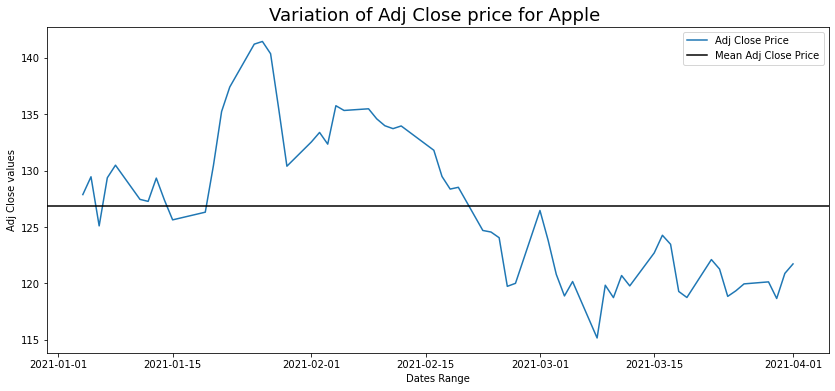

In [16]:
fig, ax = plt.subplots(1,1, figsize = (14,6))
sns.lineplot(x='Date', y='Adj Close', data=apple, ax=ax)
ax.axhline(apple['Adj Close'].mean(), color='k')
ax.set_xlabel('Dates Range')
ax.set_ylabel('Adj Close values')
ax.set_title("Variation of Adj Close price for Apple ", fontsize = 18)
plt.legend(('Adj Close Price','Mean Adj Close Price'));

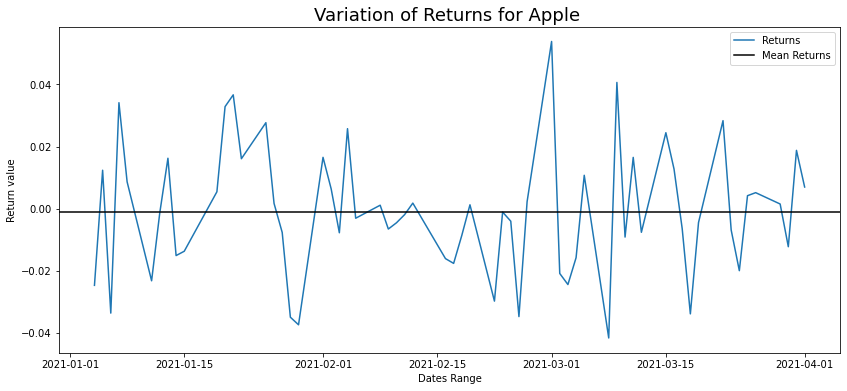

In [17]:
fig, ax = plt.subplots(1,1, figsize = (14,6))
sns.lineplot(x='Date', y='returns', data=apple, ax=ax)
ax.axhline(apple['returns'].mean(), color='k')
ax.set_xlabel('Dates Range')
ax.set_ylabel('Return value')
ax.set_title("Variation of Returns for Apple ", fontsize = 18)
plt.legend(('Returns','Mean Returns'));

* In comparision to Adj Close price, return is quite flactuating and 
* Trends and seasonality is not visible from the graph for returns

In [18]:
# Testing For Stationarity

#Null Hypothesis H0 = If failed to be rejected, it suggests the time series has a unit root, 
#                     meaning it is non-stationary

#Alternative Hypothesis H1 = The null hypothesis is rejected and suggests the time series 
#                            does not have a unit root, meaning it is stationary

def adfuller_test(returns):
    result=adfuller(returns)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(apple['returns'])

ADF Test Statistic : -8.139094784238278
p-value : 1.039806444152943e-12
#Lags Used : 0
Number of Observations Used : 61
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


We get the strong evidence that our data is stationary, which indicate its mean and variance are not varying with time and we can use tradition time series algorithm for forecasting.

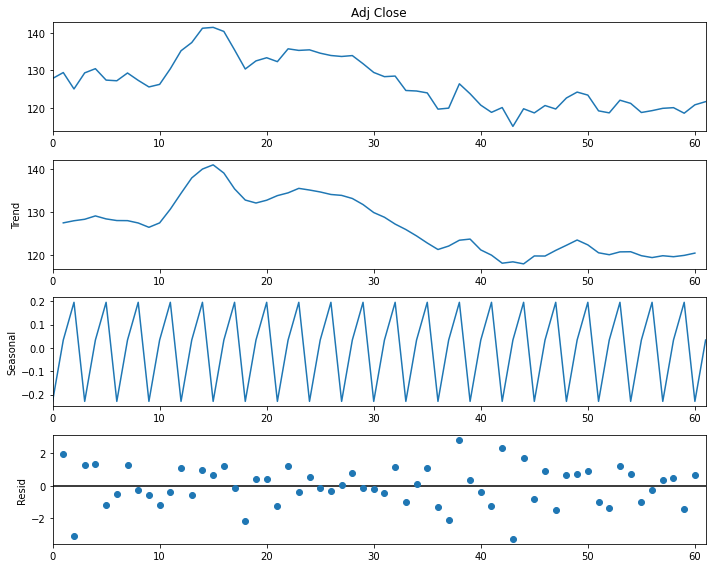

In [19]:
plt.rcParams['figure.figsize'] = (10, 8)
result = seasonal_decompose(apple['Adj Close'], model='additive', period=3)
result.plot()
plt.show();


### Autocorrelation and Partial Autocorrelation

* Identification of an AR model is often best done with the PACF.
    * For an AR model, the theoretical PACF “shuts off” past the order of the model.  The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point.  Put another way, the number of non-zero partial autocorrelations gives the order of the AR model.  By the “order of the model” we mean the most extreme lag of x that is used as a predictor.
    
    
* Identification of an MA model is often best done with the ACF rather than the PACF.
    * For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner.  A clearer pattern for an MA model is in the ACF.  The ACF will have non-zero autocorrelations only at lags involved in the model.
    
    p,d,q
    p AR model lags
    d differencing
    q MA lags

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

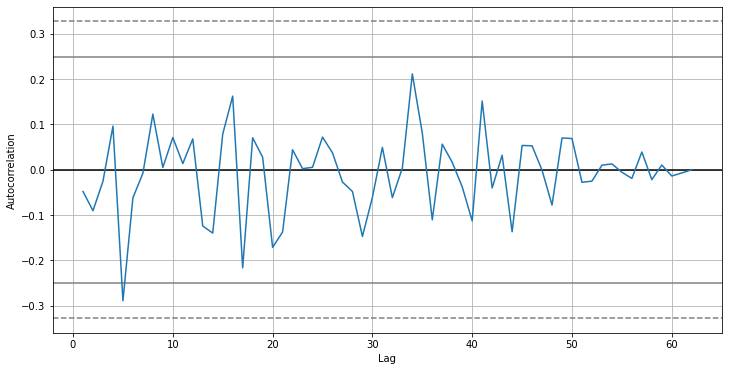

In [20]:
fig, ax = plt.subplots(1,1, figsize = (12,6))
autocorrelation_plot(apple['returns'], ax=ax)

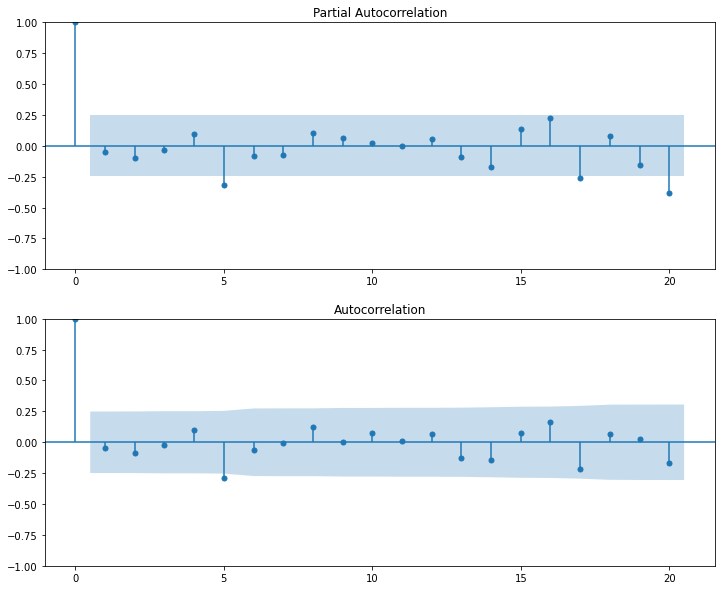

In [21]:
fig, ax = plt.subplots(2,1, figsize = (12,10))
pacf = plot_pacf(apple['returns'].dropna(),lags=20, ax=ax[0])
acf = plot_acf(apple['returns'].dropna(),lags=20, ax=ax[1])

There is no significante autocorrelation or partial autocorrelation visible, for the ARIMA model, we can take lag as 5.

## 2. ARIMA Model
### 2.1 Basic model

In [22]:
## Set date as index and seperate the data for train and test
apple = apple.set_index('Date')
apple.head()

,High,Low,Open,Close,Volume,Adj Close,returns
Date,,,,,,,
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,127.874939,-0.024719
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,129.455963,0.012364
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,125.098267,-0.033662
2021-01-07,131.630005,127.860001,128.360001,130.919998,109578200.0,129.367035,0.034123
2021-01-08,132.630005,130.229996,132.429993,132.050003,105158200.0,130.483627,0.008631


In [23]:
train_end = datetime(2021, 3, 15)
test_end = datetime(2021, 4, 1)

train_data = apple[:train_end]
test_data = apple[train_end+timedelta(days = 1):test_end]

In [24]:
## ARIMA Basic Model
train = train_data['returns']
test = test_data['returns']
arima_model = ARIMA(train, order=(1,0,1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                   49
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 119.161
Date:                Thu, 26 Jan 2023   AIC                           -230.322
Time:                        21:27:58   BIC                           -222.754
Sample:                             0   HQIC                          -227.451
                                 - 49                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0014      0.001     -1.087      0.277      -0.004       0.001
ar.L1          0.8815      0.174      5.056      0.000       0.540       1.223
ma.L1         -0.9997     16.379     -0.061      0.951     -33.103      31.103
sigma2         0.0004      0.007      0.062      0.951      -0.014       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.55
Prob(Q):                              0.91   Prob(JB):                         0.76
Heteroskedasticity (H):               1.18   Skew:                             0.13
Prob(H) (two-sided):                  0.75   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Rolling Forecast using basic ARIMA model

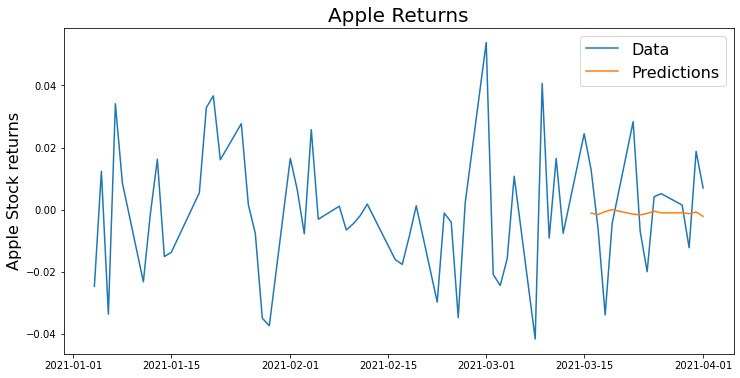

In [25]:
# rolling forecast taking into account actual data to predict next days

rolling_predictions = test_data.copy()
#rolling_predictions['rolling_forecast'] = test['returns']

for train_end in test_data.index:
    rolling_train_data = apple[:train_end - timedelta(days=1)]
    model=ARIMA(rolling_train_data['returns'],order=(1,0,1))
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    test_data.loc[train_end,'rolling_forecast'] = pred.item()
    #rolling_predictions[train_end] = pred
    
plt.figure(figsize=(12,6))

plt.plot(apple['returns'])
plt.plot(test_data['rolling_forecast'])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Apple Returns', fontsize=20)
plt.ylabel('Apple Stock returns', fontsize=16);


## Parameter Tuning for ARIMA model

In [26]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
 # prepare training dataset
    train_size = int(len(X) * 0.75)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
 # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
 # calculate out of sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    print(rmse)
    return rmse


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                print(order)
                rmse = evaluate_arima_model(dataset, order)
                if rmse < best_score:
                    best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    
    

In [27]:
# evaluate parameters
p_values = [1, 4, 5, 6, 7, 14]
d_values = [0, 1, 2, 3, 5]
q_values = [1, 2, 3, 4, 5, 6, 7]
warnings.filterwarnings("ignore")
#evaluate_models(apple['Adj Close'], p_values, d_values, q_values)

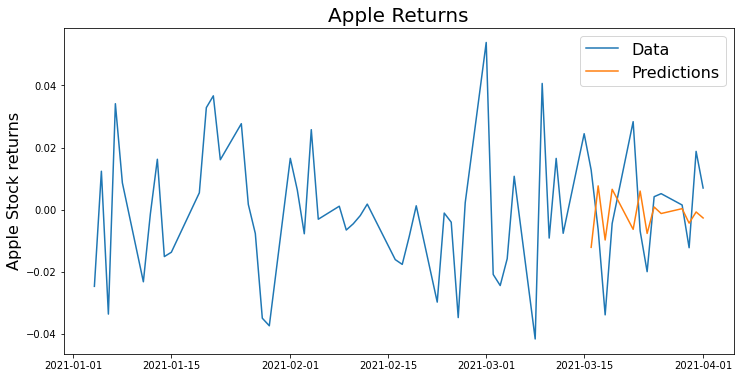

In [33]:
# rolling forecast taking into account actual data to predict next days

rolling_predictions = test_data.copy()
#rolling_predictions['rolling_forecast'] = test['returns']

for train_end in test_data.index:
    rolling_train_data = apple[:train_end - timedelta(days=1)]
    model=ARIMA(rolling_train_data['returns'],order=(3,1,2))
    model_fit = model.fit()
    
    pred = model_fit.forecast()
    test_data.loc[train_end,'rolling_forecast'] = pred.item()
    #rolling_predictions[train_end] = pred
    
plt.figure(figsize=(12,6))

plt.plot(apple['returns'])
plt.plot(test_data['rolling_forecast'])

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Apple Returns', fontsize=20)
plt.ylabel('Apple Stock returns', fontsize=16);



## TODO: 
1) Buy-Sell rule

2) Experiments with more models
             